In [1]:
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import seaborn as sns

import anndata as ad
import spatialdata as sd
import spatialdata_plot
from spatialdata import SpatialData
from spatialdata_io import xenium
from spatialdata import polygon_query

import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib_venn import venn3
from matplotlib.colors import ListedColormap

from lightning.pytorch import seed_everything

import os

import mygene

import copy

import contextlib
import logging

from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde 
from scipy.signal import find_peaks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, adjusted_rand_score

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
varrone_df = pd.read_csv('/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_cell_types.csv')

In [3]:
adata_big = sc.read_h5ad("/mnt/ptemp/virginia/project/breast_cancer_atlas_cellxgene_epithelial.h5ad")

In [4]:
adata_small = sc.read('/mnt/ptemp/virginia/project/cbbb607f-578b-47ba-858b-407bb8be917f.h5ad')

In [5]:
xenium = sd.read_zarr("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC.zarr")

In [6]:
adata_small.X = adata_small.raw.X 
adata_small.X.data

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [7]:
#1. Filtro adata_small e mantengo solo le cellule epiteliali
adata_small_epit = adata_small[
    (adata_small.obs['celltype_major'].isin(['Normal Epithelial', 'Cancer Epithelial']))].copy()

In [8]:
#2. Modifico i nomi in adata_small_epit ovvero Cancer Epithelial in Malignant_epithelial e Normal Epithelial in Normal_epithelial 
adata_small_epit.obs["celltype_major"] = adata_small_epit.obs["celltype_major"].replace(
    {"Cancer Epithelial": "Malignant_epithelial", "Normal Epithelial": "Normal_epithelial"})

In [9]:
# Recupera la tabella associata (di solito c'è un solo elemento in .tables)
xenium_table = list(xenium.tables.values())[0]

# Recupera gli Ensembl IDs
xenium_gene_ids = xenium_table.var['gene_ids'].tolist()

# Recupero gli Ensembl IDs da adata_new.var_names
adata_gene_ids = adata_big.var['feature_id'].tolist()  

# Confronto gli ID dei geni
only_in_xenium = set(xenium_gene_ids) - set(adata_gene_ids)
only_in_adata = set(adata_gene_ids) - set(xenium_gene_ids)

print(f"Genes only in xenium: {len(only_in_xenium)}")  
print(f"Genes only in adata_big: {len(only_in_adata)}")

# Filtro adata_big per mantenere solo i geni che sono in 'xenium'
adata_big_filtered = adata_big[:, adata_big.var['feature_id'].isin(xenium_gene_ids)]
print(f"After filtering, the shape of adata_big_filtered is: {adata_big_filtered.shape}")  

Genes only in xenium: 0
Genes only in adata_big: 61608
After filtering, the shape of adata_big_filtered is: (1101803, 280)


In [10]:
adata_big_filtered = adata_big_filtered.copy()

adata_big_filtered.layers["counts"] = adata_big_filtered.X.copy()
adata_big_filtered.var = adata_big_filtered.var[['feature_id'] + 
                                                [col for col in adata_big_filtered.var.columns if col != 'feature_id']]
adata_big_filtered.var.set_index("feature_id", inplace=True)

In [11]:
#3. Creo un terzo anndata unendo adata_small e adata_big e lo faccio in base ai nomi Normal_epithelial e Malignant_epithelial
adata_combined = ad.concat([adata_small_epit, adata_big_filtered], join="outer")

In [12]:
adata_xenium = xenium.tables['table']

In [13]:
adata_xenium_cell_ids = set(adata_xenium.obs['cell_id'])

In [14]:
filtered_varrone_df = varrone_df[varrone_df['cell_id'].isin(adata_xenium_cell_ids)]

In [15]:
# Aggiungo la colonna 'level1' da varrone_df a adata_original.obs in base al 'cell_id'
adata_xenium.obs['level1'] = adata_xenium.obs['cell_id'].map(filtered_varrone_df.set_index('cell_id')['level1'])
adata_xenium.obs['level2'] = adata_xenium.obs['cell_id'].map(filtered_varrone_df.set_index('cell_id')['level2'])

adata_xenium.obs['level2'] = adata_xenium.obs['level2'].replace({
    'Malignant_epithelial': 'Malignant',
    'Normal_epithelial': 'Normal'})

In [16]:
# ***DATASET INIZIALE USATO PER LE ANALISI***

# Filtro l'AnnData per includere solo le cellule con 'Epithelial' in 'level1'
epithelial_cells = adata_xenium[adata_xenium.obs['level1'] == 'Epithelial'].copy()
print(f"Number of epithelial cells: {epithelial_cells.shape[0]}")  

# Salvo 'epithelial_cells' 
epithelial_cells = epithelial_cells.copy()
epithelial_cells.write("epithelial_cells_level2.h5ad")

Number of epithelial cells: 350729


In [17]:
# PER VALUTARE QUALE DATASET USARE e PER CREARE IL FILE CON epithelial_cells CHE CONTIENE 'cell_type_prediction'
epithelial_cells.var_names = epithelial_cells.var['gene_ids']

In [18]:
sc.pp.normalize_total(epithelial_cells, inplace=True)
sc.pp.log1p(epithelial_cells)

In [19]:
# DATASET: IDC TUMOR + IDC NORMAL 

# Filtro combinato per includere: 
# - IDC (ductal) con 'malignant' e 'normal'

adata_filtered_IDC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) 
].copy()

adata_filtered_IDC

AnnData object with n_obs × n_vars = 22196 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [20]:
# DATASET SCELTO: IDC TUMOR + IDC NORMAL + ILC NORMAL !!!!!!

# Filtro combinato per includere:
# - IDC (ductal) con 'malignant' e 'normal'
# - ILC (lobular) solo con 'normal'

adata_filtered_IDC_normal_ILC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) |
    (
        (adata_combined.obs['disease'] == 'invasive lobular breast carcinoma') &
        (adata_combined.obs['celltype_major'] == 'Normal_epithelial')
    )
].copy()

adata_filtered_IDC_normal_ILC

AnnData object with n_obs × n_vars = 24184 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [21]:
# DATASET: IDC TUMOR + IDC NORMAL + ILC NORMAL + ILC TUMOR

# Filtro combinato per includere:
# - IDC (ductal) con 'malignant' e 'normal'
# - ILC (lobular) con 'malignant' e 'normal'

adata_filtered_IDC_ILC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) |
    (
        (adata_combined.obs['disease'] == 'invasive lobular breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    )
].copy()

adata_filtered_IDC_ILC

AnnData object with n_obs × n_vars = 26619 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [22]:
# Lista dei dataset da analizzare
datasets = {
    "IDC(N+T)": adata_filtered_IDC,
    "IDC(N+T) + ILC(N)": adata_filtered_IDC_normal_ILC,
    "IDC(N+T) + ILC(N+T)": adata_filtered_IDC_ILC
}

# Loop su tutti i dataset
for name, adata in datasets.items():
    n_malignant = adata.obs[adata.obs['celltype_major'] == 'Malignant_epithelial'].shape[0]
    n_normal = adata.obs[adata.obs['celltype_major'] == 'Normal_epithelial'].shape[0]
    
    print(f"Dataset: {name}")
    print(f"  Malignant epithelial cells: {n_malignant}")
    print(f"  Normal epithelial cells: {n_normal}\n")

Dataset: IDC(N+T)
  Malignant epithelial cells: 19829
  Normal epithelial cells: 2367

Dataset: IDC(N+T) + ILC(N)
  Malignant epithelial cells: 19829
  Normal epithelial cells: 4355

Dataset: IDC(N+T) + ILC(N+T)
  Malignant epithelial cells: 22264
  Normal epithelial cells: 4355



In [23]:
# Filtraggio warning di Scanpy/MyGene
warnings.filterwarnings("ignore", message="Dendrogram not added")
warnings.filterwarnings("ignore", message="Input sequence provided is already in string format")


def compute_scores(datasets, epithelial_cells, group="celltype_major", variable="logfoldchanges", n_genes=50):
    """
    Esegue DGE, salva i top genes maligni e normali e calcola score sulle cellule epiteliali.    
    Ritorna un dizionario con i top genes maligni e normali selezionati per ciascun dataset.
    """
    signature_dict = {}
    
    for name, adata in datasets.items():
        print(f"\nProcessing dataset: {name}")
        
        # Normalizzazione e log1p
        sc.pp.normalize_total(adata, inplace=True)
        sc.pp.log1p(adata)
        
        # Filtro geni presenti in epithelial_cells
        adata_filtered = adata[:, adata.var_names.isin(epithelial_cells.var_names)].copy()
        print(f"Number of genes after filtering: {len(adata_filtered.var_names)}")
        
        # DGE
        sc.tl.rank_genes_groups(adata_filtered, groupby=group, method="wilcoxon")
        
        # Dotplot senza messaggi Scanpy
        with contextlib.redirect_stdout(open(os.devnull, "w")):
            sc.pl.rank_genes_groups_dotplot(
                adata_filtered,
                groupby=group,
                standard_scale="var",
                n_genes=10,
                title=f"Marker Genes {name}",
                show=False,
                save=f"Marker_Genes_{name}.pdf"
            )

        # Salvataggio dei geni maligni
        cancer_genes = sc.get.rank_genes_groups_df(adata_filtered, group="Malignant_epithelial")
        os.makedirs("results", exist_ok=True)
        cancer_genes.to_csv(f'results/cancer_genes_Malignant_epithelial_{name}.csv', index=False)
        
        # Filtraggio geni significativi
        df_epit_selected_cancer = cancer_genes[(cancer_genes[variable] > 0.58) & (cancer_genes['pvals'] <= 0.01)]
        df_epit_selected_cancer = df_epit_selected_cancer.sort_values(by=variable, ascending=False).head(n_genes)['names'].tolist()

        df_epit_selected_normal = cancer_genes[(cancer_genes[variable] < -0.58) & (cancer_genes['pvals'] <= 0.01)]
        df_epit_selected_normal = df_epit_selected_normal.sort_values(by=variable, ascending=True).head(n_genes)['names'].tolist()

        # Score sulle cellule epiteliali
        sc.tl.score_genes(epithelial_cells, df_epit_selected_cancer, ctrl_as_ref=True, score_name=f'{name}_malignant_signature')
        sc.tl.score_genes(epithelial_cells, df_epit_selected_normal, ctrl_as_ref=True, score_name=f'{name}_normal_signature')
        
        # Salvataggio nel dizionario
        signature_dict[name] = {
            "malignant": df_epit_selected_cancer,
            "normal": df_epit_selected_normal
        }
        
        print(f"Saved scores for {name}: {len(df_epit_selected_cancer)} malignant genes, {len(df_epit_selected_normal)} normal genes")
            
    return signature_dict


def clean_epithelial_cells(epithelial_cells):
    """Rimuove colonne non necessarie e rinomina la normal_signature"""
    cols_to_drop = [c for c in epithelial_cells.obs.columns if c in ['IDC_malignant_signature', 'IDC_ILC_malignant_signature']]
    epithelial_cells.obs.drop(columns=cols_to_drop, inplace=True)
    
    # Rinominare la colonna normal
    if 'IDC-and_Normal_ILC_malignant_signature' in epithelial_cells.obs.columns:
        epithelial_cells.obs.rename(columns={'IDC-and_Normal_ILC_malignant_signature': 'malignant_signature'}, inplace=True)


def convert_ensembl_to_symbol(signature_dict):
    """Converte una lista di Ensembl IDs in simboli genici usando MyGene."""
    mg = mygene.MyGeneInfo()
    converted_dfs = {}
    
    for name, genes_dict in signature_dict.items():
        converted_dfs[name] = {}
        for key, gene_list in genes_dict.items():
            cleaned_ids = [g.split('.')[0] for g in gene_list]

            # Silenzia stdout e stderr di MyGene
            with contextlib.redirect_stdout(open(os.devnull, "w")), \
                 contextlib.redirect_stderr(open(os.devnull, "w")):
                results = mg.querymany(
                    cleaned_ids,
                    scopes='ensembl.gene',
                    fields='symbol',
                    species='human'
                )
            
            id_to_symbol = {r['query']: r.get('symbol', 'NA') for r in results}
            gene_symbols = [id_to_symbol.get(g.split('.')[0], 'NA') for g in gene_list]
            
            df = pd.DataFrame({
                "ensembl_id": gene_list,
                "gene_symbol": gene_symbols
            })
            converted_dfs[name][key] = df
        
    return converted_dfs


def plot_malignant_heatmap(converted_dfs, output_file="figures/malignant_gene_symbol_heatmap.pdf"):
    """
    Crea una heatmap binaria dei geni maligni presenti nei vari dataset.
    Parameters:
        converted_dfs (dict): Dizionario con i DataFrame convertiti in simboli genici, solo signature malignant
        output_file (str): Path del file in cui salvare la heatmap
    """
    # Step 1: Crea un dizionario con insiemi di simboli genici (solo malignant)
    gene_sets_symbol = {
        name: set(df['malignant']['gene_symbol']) - {"NA", ""}  # rimuove simboli mancanti
        for name, df in converted_dfs.items()
        if 'malignant' in df
    }

    # Step 2: Ottieni tutti i simboli genici unici
    all_genes = sorted(set().union(*gene_sets_symbol.values()))

    # Step 3: Crea la matrice binaria
    data = {
        group: [1 if gene in gene_sets_symbol[group] else 0 for gene in all_genes]
        for group in gene_sets_symbol
    }

    df_binary = pd.DataFrame(data, index=all_genes)

    # Step 4: Plot della heatmap binaria
    bw_cmap = ListedColormap(["white", "black"])
    plt.figure(figsize=(6, len(df_binary) * 0.25))
    sns.heatmap(
        df_binary,
        cmap=bw_cmap,
        cbar=False,
        linewidths=0.5,
        linecolor='grey'
    )

    plt.title("Malignant gene presence across IDC/ILC signatures", fontsize=14)
    plt.xlabel("Signature", fontsize=12)
    plt.ylabel("Gene Symbol", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


def plot_malignant_venn(converted_dfs, output_file="figures/malignant_venn_signatures.pdf"):
    """
    Crea un Venn plot dei geni maligni condivisi tra i tre dataset.
    
    Parameters:
        converted_dfs (dict): Dizionario con i DataFrame convertiti in simboli genici, solo signature malignant
        output_file (str): Path del file in cui salvare il plot
    """
    sets = []
    labels = []
    
    for name, df_dict in converted_dfs.items():
        if 'malignant' in df_dict:
            sets.append(set(df_dict['malignant']['gene_symbol']) - {"NA", ""})
            labels.append(name)
    
    if len(sets) != 3:
        print("Venn plot requires exactly 3 sets.")
        return
    
    plt.figure()
    venn3(sets, set_labels=tuple(labels))
    plt.title("Malignant gene overlap between signatures")
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


Processing dataset: IDC(N+T)
Number of genes after filtering: 280
Saved scores for IDC(N+T): 43 malignant genes, 48 normal genes

Processing dataset: IDC(N+T) + ILC(N)
Number of genes after filtering: 280
Saved scores for IDC(N+T) + ILC(N): 45 malignant genes, 50 normal genes

Processing dataset: IDC(N+T) + ILC(N+T)
Number of genes after filtering: 280
Saved scores for IDC(N+T) + ILC(N+T): 43 malignant genes, 50 normal genes


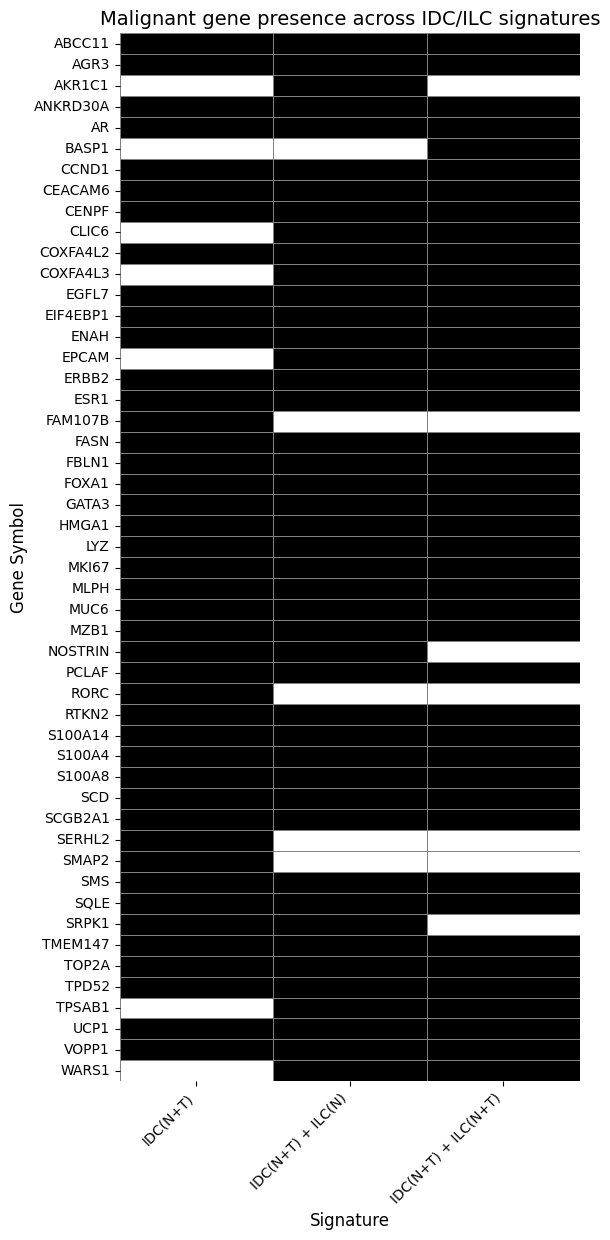

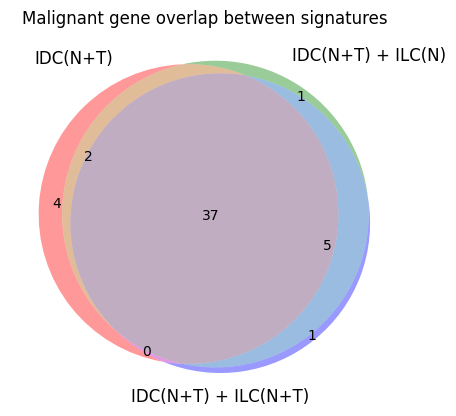

In [24]:
logging.getLogger("mygene").setLevel(logging.ERROR)

#prepare_directories()

# STEP 1: DGE e score
signature_dict = compute_scores(
    datasets={
        "IDC(N+T)": adata_filtered_IDC,
        "IDC(N+T) + ILC(N)": adata_filtered_IDC_normal_ILC,
        "IDC(N+T) + ILC(N+T)": adata_filtered_IDC_ILC
    },
    epithelial_cells=epithelial_cells
)

# STEP 2: Conversione Ensembl → Symbol
converted_dfs = convert_ensembl_to_symbol(signature_dict)

# STEP 3: Heatmap binaria
plot_malignant_heatmap(converted_dfs)

# STEP 4: Venn plot
plot_malignant_venn(converted_dfs)

In [31]:
# Rimuovo le colonne che non mi servono (lascio solo le colonne per il dataset IDC(N+T) + ILC(N)
cols_to_drop = ["IDC(N+T)_malignant_signature", "IDC(N+T)_normal_signature", "IDC(N+T) + ILC(N+T)_malignant_signature", "IDC(N+T) + ILC(N+T)_normal_signature"]
epithelial_cells.obs.drop(columns=[c for c in cols_to_drop if c in epithelial_cells.obs.columns], inplace=True)

# Rinomino la colonna per semplicità
if "IDC(N+T) + ILC(N)_malignant_signature" in epithelial_cells.obs.columns:
    epithelial_cells.obs.rename(columns={"IDC(N+T) + ILC(N)_malignant_signature": "malignant_signature"}, inplace=True)
if "IDC(N+T) + ILC(N)_normal_signature" in epithelial_cells.obs.columns:
    epithelial_cells.obs.rename(columns={"IDC(N+T) + ILC(N)_normal_signature": "normal_signature"}, inplace=True)

In [32]:
# *** DATASET FILTRATO: QUALITY FILTERING SULLE CELLULE EPITELIALI***

# Filter all cells with total_counts > 10
epi_filtered = epithelial_cells[epithelial_cells.obs["total_counts"] > 10].copy()
print(f"Total epithelial cells with total_counts > 10: {epi_filtered.shape[0]}")

# Count of filtered cells per cell type
filtered_counts_per_type = epi_filtered.obs['cell_type_prediction'].value_counts()
print("Number of filtered cells per cell type (total_counts > 10):")
print(filtered_counts_per_type)

# Salvo il dataset filtrato
epi_filtered.write("epi_filtered.h5ad")

Total epithelial cells with total_counts > 10: 348692
Number of filtered cells per cell type (total_counts > 10):
cell_type_prediction
Malignant    319136
Normal        25245
Unknown        4311
Name: count, dtype: int64


Cell type counts:
 cell_type_prediction
Malignant    319136
Normal        25245
Unknown        4311
Name: count, dtype: int64


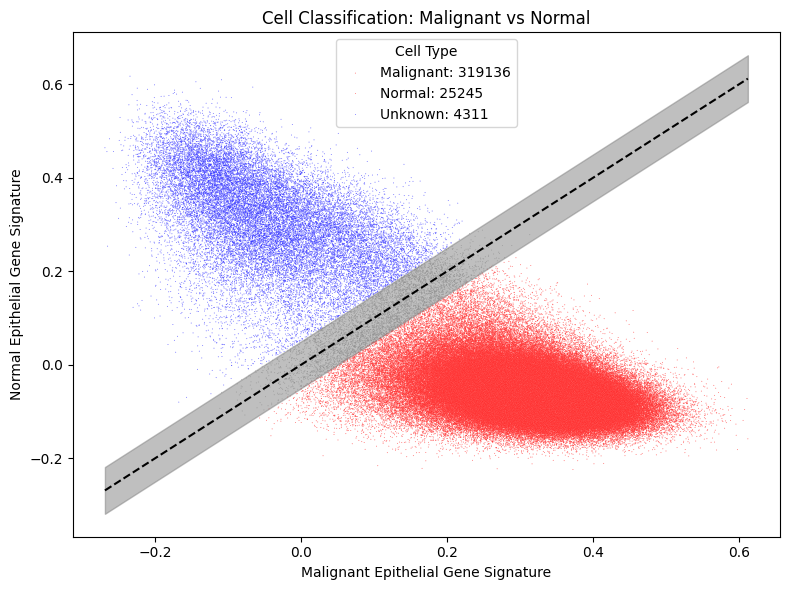

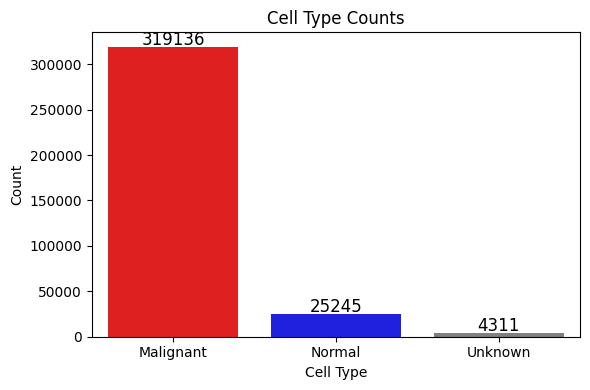

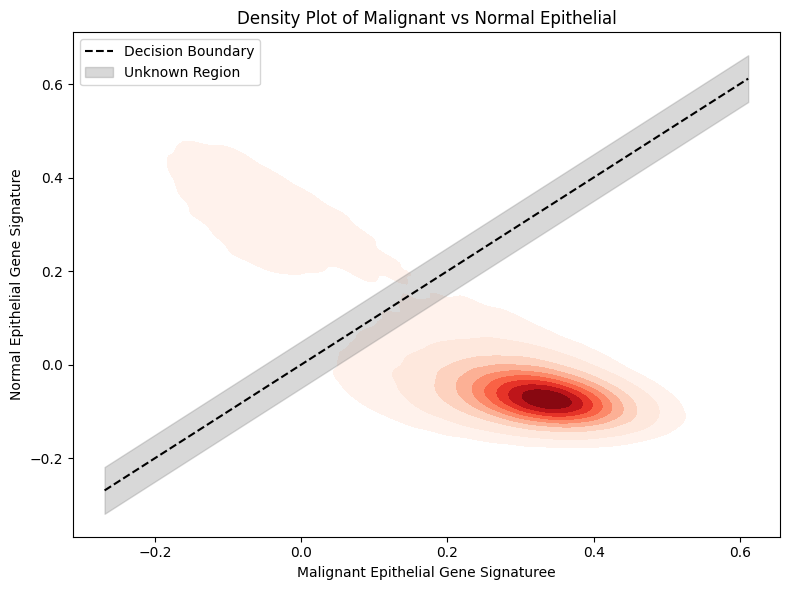

In [33]:
x = epi_filtered.obs['malignant_signature']
y = epi_filtered.obs['normal_signature']

# Parametro: larghezza della fascia "unknown"
boundary_width = 0.05

diff = y - x

def classify(diff_value, threshold):
    if diff_value > threshold:
        return 'Normal'
    elif diff_value < -threshold:
        return 'Malignant'
    else:
        return 'Unknown'

epi_filtered.obs['cell_type_prediction'] = diff.apply(lambda d: classify(d, threshold=boundary_width))

# Conto le cellule per categoria
cell_counts = epi_filtered.obs['cell_type_prediction'].value_counts()
print("Cell type counts:\n", cell_counts)

# --- SCATTERPLOT CON DIAGONALE E BOUNDARY "UNKNOWN" ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=x,
    y=y,
    hue=epi_filtered.obs['cell_type_prediction'],
    hue_order=['Malignant', 'Normal', 'Unknown'], 
    palette={'Malignant': 'red', 'Normal': 'blue', 'Unknown': 'gray'},
    alpha=0.6,
    s=0.5)

plt.plot([x.min(), x.max()], [x.min(), x.max()], color='black', linestyle='--', label='Decision Boundary')
x_vals = np.linspace(x.min(), x.max(), 500)
plt.fill_between(x_vals, x_vals - boundary_width, x_vals + boundary_width, 
                 color='gray', alpha=0.5, label='Unknown Region')
plt.xlabel('Malignant Epithelial Gene Signature')
plt.ylabel('Normal Epithelial Gene Signature')
plt.title('Cell Classification: Malignant vs Normal')
plt.legend(title="Cell Type", labels=[
    f"Malignant: {cell_counts.get('Malignant', 0)}", 
    f"Normal: {cell_counts.get('Normal', 0)}", 
    f"Unknown: {cell_counts.get('Unknown', 0)}"
])
plt.tight_layout()
plt.savefig("figures/scatter_malignant_vs_normal_epi_filtered.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# --- BARPLOT CONTEGGIO CELLULE ---
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=cell_counts.index, y=cell_counts.values, palette=['red', 'blue', 'gray'])
plt.title('Cell Type Counts')
plt.xlabel('Cell Type')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.savefig("figures/barplot_cell_counts_epi_filtered.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# --- DENSITY PLOT ---
plt.figure(figsize=(8, 6))
sns.kdeplot(x=x, y=y, cmap="Reds", fill=True, thresh=0.05)
plt.plot([x.min(), x.max()], [x.min(), x.max()], color='black', linestyle='--', label='Decision Boundary')
plt.fill_between(x_vals, x_vals - boundary_width, x_vals + boundary_width, 
                 color='gray', alpha=0.3, label='Unknown Region')
plt.xlabel('Malignant Epithelial Gene Signaturee')
plt.ylabel('Normal Epithelial Gene Signature')
plt.title('Density Plot of Malignant vs Normal Epithelial')
plt.legend()
plt.tight_layout()
plt.savefig("figures/density_malignant_vs_normal_epi_filtered.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [34]:
# Carico l'anndata iniziale dove ho salvato solo le cellule epitheliali e la classificazione level1 e level2
epithelial_cells_old = sc.read_h5ad("epithelial_cells_level2.h5ad")

# Aggiungo al file iniziale la colonna cell_type_prediction (in questo modo i gene_symbol rimangono intatti)
# Copia le colonne da epithelial_cells a epithelial_cells_old
epithelial_cells_old.obs['malignant_signature'] = epi_filtered.obs['malignant_signature']
epithelial_cells_old.obs['normal_signature'] = epi_filtered.obs['normal_signature']
epithelial_cells_old.obs['cell_type_prediction'] = epi_filtered.obs['cell_type_prediction']

# Salvo il file
epi_filtered.write("epithelial_cells_cell_type_prediction_filtered.h5ad")